In [2]:
%load_ext autoreload
%autoreload 2

In [61]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import albumentations as A
from src.data_loader import RotatedImagesDataset

### Visualize raw dataset

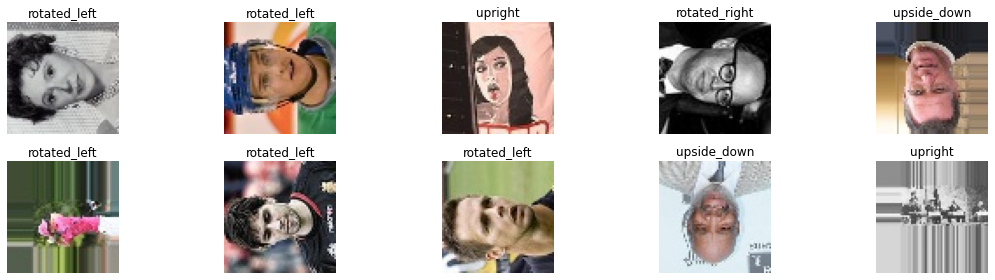

In [25]:
rotated_dataset_loader = RotatedImagesDataset("dataset/images", "dataset/ground-truth.csv")
images_to_show = rotated_dataset_loader[0:10]

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 4))
for i, image_label in enumerate(images_to_show):
    ax.ravel()[i].imshow(image_label[0])
    ax.ravel()[i].set_title(image_label[1])
    ax.ravel()[i].set_axis_off()
plt.tight_layout()
plt.show()

### Visualize augmented dataset

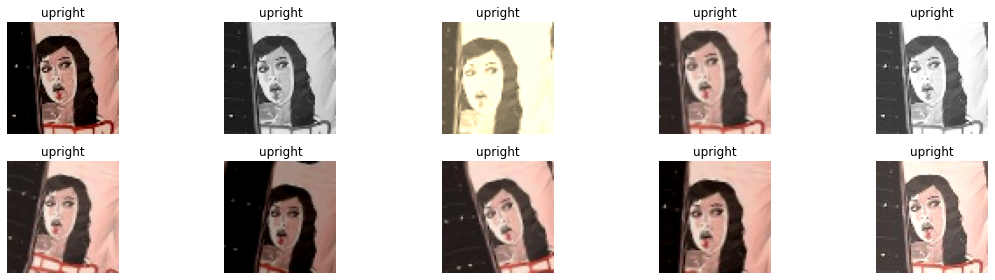

In [81]:
dataset_transform = A.Compose(
    [
        A.ShiftScaleRotate(p=0.6, shift_limit=0.1, rotate_limit=15),
        A.RandomBrightnessContrast(p=0.7),
        A.ToGray(p=0.3),
        A.ToSepia(p=0.2),
    ]
)
rotated_dataset_loader = RotatedImagesDataset("dataset/images", "dataset/ground-truth.csv", transform=dataset_transform)

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 4))
image_augmented_samples = 10
for i in range(image_augmented_samples):
    image = rotated_dataset_loader[2]
    ax.ravel()[i].imshow(image[0])
    ax.ravel()[i].set_title(image[1])
    ax.ravel()[i].set_axis_off()
plt.tight_layout()
plt.show()